In [8]:
from IPython.display import clear_output

!unzip archive.zip

clear_output()

In [39]:
from pathlib import Path
from datasets import Dataset

def build_hf_dataset(data_dir: Path):
    class_names = sorted([d.name for d in data_dir.iterdir() if d.is_dir()])
    name2idx = {n: i for i, n in enumerate(class_names)}
    data = [(str(img_file), name2idx[img_file.parent.name]) for cname in class_names for img_file in (data_dir / cname).glob('*.jpg')]
    image_paths, labels = zip(*data)
    ds = Dataset.from_dict({'image_path': image_paths, 'label': labels})
    return ds, class_names

# Test building
hf_ds, class_names = build_hf_dataset(Path('images'))
print(class_names, len(hf_ds))

['Abomasnow', 'Abra', 'Absol', 'Accelgor', 'Aegislash', 'Aerodactyl', 'Aggron', 'Aipom', 'Alakazam', 'Alcremie', 'Alomomola', 'Altaria', 'Amaura', 'Ambipom', 'Amoonguss', 'Ampharos', 'Anorith', 'Appletun', 'Applin', 'Araquanid', 'Arbok', 'Arcanine', 'Arceus', 'Archen', 'Archeops', 'Arctovish', 'Arctozolt', 'Ariados', 'Armaldo', 'Aromatisse', 'Aron', 'Arrokuda', 'Articuno', 'Audino', 'Aurorus', 'Avalugg', 'Axew', 'Azelf', 'Azumarill', 'Azurill', 'Bagon', 'Baltoy', 'Banette', 'Barbaracle', 'Barboach', 'Barraskewda', 'Basculin', 'Bastiodon', 'Bayleef', 'Beartic', 'Beautifly', 'Beedrill', 'Beheeyem', 'Beldum', 'Bellossom', 'Bellsprout', 'Bergmite', 'Bewear', 'Bibarel', 'Bidoof', 'Binacle', 'Bisharp', 'Blacephalon', 'Blastoise', 'Blaziken', 'Blipbug', 'Blissey', 'Blitzle', 'Boldore', 'Boltund', 'Bonsly', 'Bouffalant', 'Bounsweet', 'Braixen', 'Braviary', 'Breloom', 'Brionne', 'Bronzong', 'Bronzor', 'Bruxish', 'Budew', 'Buizel', 'Bulbasaur', 'Buneary', 'Bunnelby', 'Burmy', 'Butterfree', 'Buzz

In [40]:
from torch.utils.data import Dataset as TorchDataset
from PIL import Image

class PokemonDataset(TorchDataset):
    def __init__(self, hf_ds, transform=None):
        self.ds = hf_ds
        self.transform = transform
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, idx):
        item = self.ds[int(idx)]
        img = Image.open(item['image_path']).convert('RGB')
        label = item['label']
        if self.transform:
            img = self.transform(img)
        return img, label

In [41]:
import torch.nn as nn
from torchvision import models
from torch.nn import Dropout

class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.dropout = Dropout(p=0.6)
        self.out_layer = nn.Linear(self.backbone.fc.out_features, num_classes)
    def forward(self, x):
        return self.out_layer(self.dropout(self.backbone(x)))

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from pathlib import Path
from sklearn.metrics import f1_score, precision_score, recall_score

def train_model(
    data_dir: str,
    batch_size: int = 16,
    epochs: int = 10,
    lr: float = 3e-4,
    test_split: float = 0.2,
    log_dir: str = './runs',
    save_path: str = './best_model.pth'
) -> list:
    # Prepare HF dataset and transforms
    hf_ds, class_names = build_hf_dataset(Path(data_dir))
    data_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    full_dataset = PokemonDataset(hf_ds, data_transform)

    # Split dataset into training and validation sets
    n_train = int(len(full_dataset) * (1 - test_split))
    train_dataset, val_dataset = random_split(full_dataset, [n_train, len(full_dataset) - n_train])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize device, model, criterion, and optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNNClassifier(len(class_names)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Initialize TensorBoard writer
    writer = SummaryWriter(log_dir=log_dir)

    # Train the model
    best_acc = 0.0
    for epoch in range(1, epochs + 1):
        # Training phase
        model.train()
        running_loss = correct = total = 0
        train_preds = []
        train_labels = []
        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch} Training"):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        train_loss = running_loss / total
        train_acc = correct / total
        train_f1 = f1_score(train_labels, train_preds, average='macro')
        train_precision = precision_score(train_labels, train_preds, average='macro')
        train_recall = recall_score(train_labels, train_preds, average='macro')
        writer.add_scalar('Train/Loss', train_loss, epoch)
        writer.add_scalar('Train/Accuracy', train_acc, epoch)
        writer.add_scalar('Train/F1', train_f1, epoch)
        writer.add_scalar('Train/Precision', train_precision, epoch)
        writer.add_scalar('Train/Recall', train_recall, epoch)

        # Validation phase
        model.eval()
        val_loss = val_correct = val_total = 0
        val_preds = []
        val_labels = []
        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch} Validation"):
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * imgs.size(0)
                preds = outputs.argmax(dim=1)
                val_correct += preds.eq(labels).sum().item()
                val_total += labels.size(0)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        val_loss /= val_total
        val_acc = val_correct / val_total
        val_f1 = f1_score(val_labels, val_preds, average='macro')
        val_precision = precision_score(val_labels, val_preds, average='macro')
        val_recall = recall_score(val_labels, val_preds, average='macro')
        writer.add_scalar('Val/Loss', val_loss, epoch)
        writer.add_scalar('Val/Accuracy', val_acc, epoch)
        writer.add_scalar('Val/F1', val_f1, epoch)
        writer.add_scalar('Val/Precision', val_precision, epoch)
        writer.add_scalar('Val/Recall', val_recall, epoch)

        print(f"Epoch {epoch}/{epochs}  "
              f"train_loss={train_loss:.4f}  train_acc={train_acc:.4f}  train_f1={train_f1:.4f}  "
              f"val_loss={val_loss:.4f}  val_acc={val_acc:.4f}  val_f1={val_f1:.4f}")

        # Save the best model based on validation accuracy
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), save_path)

    writer.close()
    print(f"Best validation accuracy: {best_acc:.4f}")
    return class_names


In [43]:
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from pathlib import Path
from sklearn.metrics import f1_score, precision_score, recall_score

def evaluate_model(
    data_dir: str,
    class_names: list,
    save_path: str = './best_model.pth',
    batch_size: int = 16,
    test_split: float = 0.2,
    num_examples: int = 8
) -> None:
    # Prepare HF dataset and transforms
    hf_ds, _ = build_hf_dataset(Path(data_dir))
    data_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    full_dataset = PokemonDataset(hf_ds, data_transform)

    # Split dataset into training and test sets
    n_train = int(len(full_dataset) * (1 - test_split))
    _, test_dataset = random_split(full_dataset, [n_train, len(full_dataset) - n_train])
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Initialize device and model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNNClassifier(len(class_names)).to(device)
    model.load_state_dict(torch.load(save_path, map_location=device))
    model.eval()

    # Evaluate the model on the test set
    all_preds, all_labels = [], []
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.tolist())
    test_acc = sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)
    test_f1 = f1_score(all_labels, all_preds, average='macro')
    test_precision = precision_score(all_labels, all_preds, average='macro')
    test_recall = recall_score(all_labels, all_preds, average='macro')
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")

    # Visualize examples
    idxs = random.sample(range(len(test_dataset)), num_examples)
    fig, axes = plt.subplots(nrows=num_examples // 4, ncols=4, figsize=(12, num_examples // 4 * 3))
    for i, (idx, ax) in enumerate(zip(idxs, axes.flatten()), 1):
        img, label = test_dataset[idx]
        out = model(img.unsqueeze(0).to(device))
        prob = F.softmax(out, dim=1)[0]
        pred = prob.argmax().item()
        img_np = img.permute(1, 2, 0).numpy() * 0.229 + 0.485
        ax.imshow(img_np.clip(0, 1))
        ax.axis('off')
        ax.set_title(f"GT: {class_names[label]}\nPred: {class_names[pred]} ({prob[pred]:.2f})")
    plt.tight_layout()
    plt.show()


In [46]:
class_names = train_model(
    data_dir='./images',
    batch_size=16,
    epochs=10,
    lr=3e-4,
    test_split=0.3,
    log_dir='./runs',
    save_path='./best_model.pth'
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1 Training: 100%|██████████| 110/110 [00:12<00:00,  8.64it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

Epoch 1/10  train_loss=7.3722  train_acc=0.0034  train_f1=0.0011  val_loss=6.7564  val_acc=0.0213  val_f1=0.0144


Epoch 2 Training: 100%|██████████| 110/110 [00:13<00:00,  8.25it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Epoch 2 Validation: 100%|██████████| 47/47 [00:04<00:00, 10.24it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

Epoch 2/10  train_loss=6.0195  train_acc=0.0582  train_f1=0.0245  val_loss=6.0616  val_acc=0.0866  val_f1=0.0600


Epoch 3 Training: 100%|██████████| 110/110 [00:15<00:00,  7.00it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Epoch 3 Validation: 100%|██████████| 47/47 [00:03<00:00, 11.79it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this beha

Epoch 3/10  train_loss=4.4437  train_acc=0.2180  train_f1=0.1197  val_loss=5.1977  val_acc=0.1971  val_f1=0.1313


Epoch 4 Training: 100%|██████████| 110/110 [00:12<00:00,  8.57it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Epoch 4 Validation: 100%|██████████| 47/47 [00:03<00:00, 13.02it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this beha

Epoch 4/10  train_loss=2.7389  train_acc=0.4737  train_f1=0.3176  val_loss=4.5676  val_acc=0.2623  val_f1=0.1893


Epoch 5 Training: 100%|██████████| 110/110 [00:12<00:00,  8.68it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Epoch 5 Validation: 100%|██████████| 47/47 [00:03<00:00, 11.97it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this beha

Epoch 5/10  train_loss=1.4379  train_acc=0.7432  train_f1=0.5854  val_loss=3.9587  val_acc=0.3915  val_f1=0.3004


Epoch 6 Training: 100%|██████████| 110/110 [00:12<00:00,  8.71it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Epoch 6 Validation: 100%|██████████| 47/47 [00:03<00:00, 12.33it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this beha

Epoch 6/10  train_loss=0.7178  train_acc=0.8853  train_f1=0.7934  val_loss=3.4558  val_acc=0.4700  val_f1=0.3819


Epoch 7 Training: 100%|██████████| 110/110 [00:12<00:00,  8.76it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Epoch 7 Validation: 100%|██████████| 47/47 [00:03<00:00, 13.33it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this beha

Epoch 7/10  train_loss=0.3155  train_acc=0.9675  train_f1=0.9461  val_loss=3.2587  val_acc=0.5300  val_f1=0.4557


Epoch 8 Training: 100%|██████████| 110/110 [00:12<00:00,  8.75it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Epoch 8 Validation: 100%|██████████| 47/47 [00:03<00:00, 12.09it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this beha

Epoch 8/10  train_loss=0.1477  train_acc=0.9892  train_f1=0.9818  val_loss=3.0923  val_acc=0.5513  val_f1=0.4554


Epoch 9 Training: 100%|██████████| 110/110 [00:13<00:00,  8.40it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Epoch 9 Validation: 100%|██████████| 47/47 [00:03<00:00, 13.06it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this beha

Epoch 9/10  train_loss=0.0899  train_acc=0.9943  train_f1=0.9924  val_loss=3.0684  val_acc=0.5539  val_f1=0.4734


Epoch 10 Training: 100%|██████████| 110/110 [00:12<00:00,  8.77it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Epoch 10 Validation: 100%|██████████| 47/47 [00:03<00:00, 13.32it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this be

Epoch 10/10  train_loss=0.0544  train_acc=0.9971  train_f1=0.9939  val_loss=2.9952  val_acc=0.5593  val_f1=0.4692
Best validation accuracy: 0.5593


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_cla

Test Accuracy: 0.8535
Test F1 Score: 0.7713
Test Precision: 0.7740
Test Recall: 0.7882


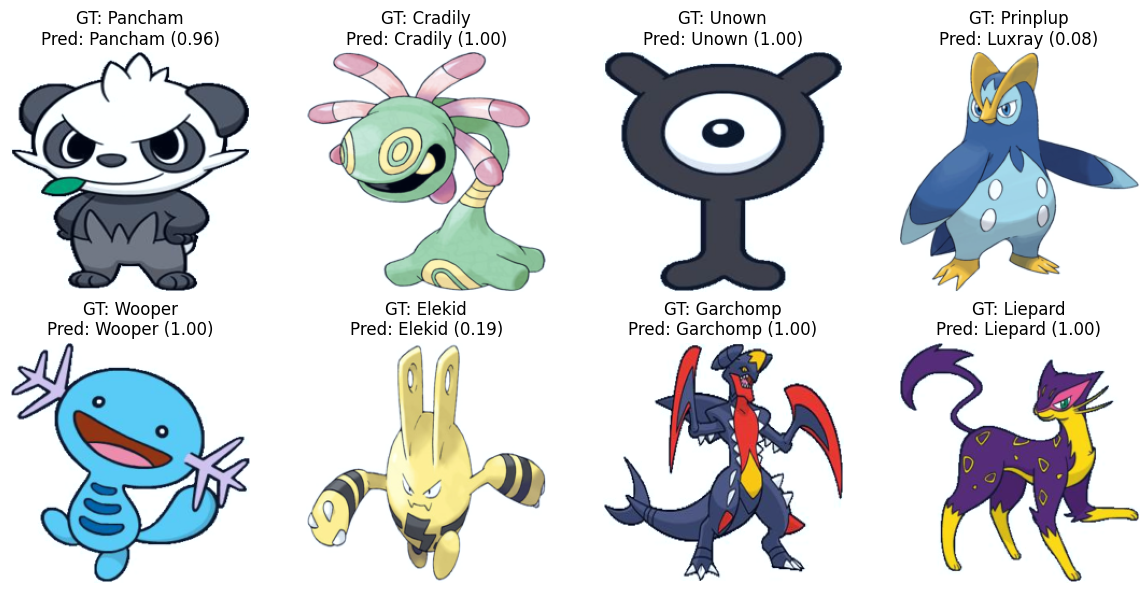

In [47]:
evaluate_model(
    data_dir='./images',
    class_names=class_names,
    save_path='./best_model.pth',
    batch_size=16,
    test_split=0.3
)

**Выводы**

Из-за большого количества классов и не очень большой выборки модель переобучается. Частично это удалось пофиксить добавлением дропаута и аугментаций, и все же все равно модель слишком хорошо выучивает трейн и достигает лишь 0.45 F1 на валидации.

При этом на тесте качество неплохое: 0.77 F1 и 0.85 accuracy.

Решить же это можно засчет еще большего количества различных аугментаций, экспериментов с архитектурой и, возможно, добавлением данных из других датасетов.